In [1]:

import warnings
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import shap
from transformers import AutoTokenizer, RobertaModel, AutoConfig
import pathlib


warnings.filterwarnings('ignore')

# --- CONFIGURATION ---

DATA_FILE    = "data/final.parquet" 
DELTA_DIR    = "out/delta_final2"
MODEL_NAME   = "mental/mental-roberta-base"

# --- PASTE THE FULL AdvancedDeltaModel CLASS DEFINITION HERE ---
# This must be identical to the class used in training script.
class AdvancedDeltaModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.num_labels = config.num_labels
        num_features = config.custom_num_features
        dropout_rate = config.custom_dropout_rate
        self.base = RobertaModel.from_pretrained(config._name_or_path)
        hidden_size = self.base.config.hidden_size
        
        # Get custom parameters directly from the config
        num_features = config.custom_num_features
        dropout_rate = config.custom_dropout_rate
        
        self.feature_encoder = nn.Sequential(nn.Linear(num_features, 256), nn.BatchNorm1d(256), nn.ReLU(), nn.Dropout(dropout_rate), nn.Linear(256, 128), nn.BatchNorm1d(128), nn.ReLU(), nn.Dropout(dropout_rate), nn.Linear(128, 64), nn.BatchNorm1d(64), nn.ReLU())
        self.text_attention = nn.MultiheadAttention(embed_dim=hidden_size, num_heads=8, dropout=dropout_rate, batch_first=True)
        self.fusion_gate = nn.Sequential(nn.Linear(hidden_size + 64, hidden_size + 64), nn.Sigmoid())
        self.pre_classifier = nn.Linear(hidden_size + 64, hidden_size)
        self.classifier_dropout = nn.Dropout(dropout_rate)
        self.classifier = nn.Linear(hidden_size, self.num_labels)
        self.feature_importance = nn.Parameter(torch.tensor(0.5))
        
    def forward(self, input_ids=None, attention_mask=None, delta=None, labels=None):
        outputs = self.base(input_ids=input_ids, attention_mask=attention_mask); sequence_output = outputs.last_hidden_state; attended_output, _ = self.text_attention(query=sequence_output,key=sequence_output,value=sequence_output,key_padding_mask=~attention_mask.bool() if attention_mask is not None else None); cls_token = attended_output[:, 0]; mean_pooled = attended_output.mean(dim=1); text_features = self.feature_importance * cls_token + (1 - self.feature_importance) * mean_pooled; behavioral_features = self.feature_encoder(delta.float()); combined_features = torch.cat([text_features, behavioral_features], dim=1); gate_values = self.fusion_gate(combined_features); fused_features = combined_features * gate_values; pooled_output = self.pre_classifier(fused_features); dropped_output = self.classifier_dropout(pooled_output); logits = self.classifier(dropped_output)
        return {"logits": logits}

print("Setup Complete.")

c:\Users\vico6\uni\nitter\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Setup Complete.


In [2]:
# Load Model, Tokenizer, and Data
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the config file
delta_config = AutoConfig.from_pretrained(DELTA_DIR)

# Load the trained model using the config
delta_model = AdvancedDeltaModel(config=delta_config).to(device)
weights_path = pathlib.Path(DELTA_DIR) / "model.safetensors"
if not weights_path.exists():
    weights_path = pathlib.Path(DELTA_DIR) / "pytorch_model.bin"

from safetensors.torch import load_file
state_dict = load_file(weights_path, device=str(device)) if weights_path.suffix == ".safetensors" else torch.load(weights_path, map_location=device)
delta_model.load_state_dict(state_dict)
delta_model.eval()

# Load tokenizer and data
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
df = pd.read_parquet(DATA_FILE)
test_df = df[df['split'] == 'test'].reset_index(drop=True)

# Get the exact feature list used in training
from sklearn.feature_selection import mutual_info_classif
def get_feature_list(df, n_features):
    exclude_cols = ['tweet_id', 'user_id', 'text', 'label', 'label_name', 'split', 'created']
    feature_cols = [c for c in df.columns if c not in exclude_cols and df[c].dtype in ['float64', 'int64']]
    if not feature_cols: return []
    train_y = df[df['split']=='train']['label'].values
    X = df[feature_cols].fillna(0).values
    mi_scores = mutual_info_classif(X[:len(train_y)], train_y, random_state=42)
    feature_scores = pd.DataFrame({'feature': feature_cols, 'score': mi_scores}).sort_values('score', ascending=False)
    return feature_scores.head(n_features)['feature'].tolist()

selected_features = get_feature_list(df, n_features=delta_config.custom_num_features)

print(f"Successfully loaded model, tokenizer, and data.")

Some weights of RobertaModel were not initialized from the model checkpoint at out/delta_final2 and are newly initialized: ['embeddings.LayerNorm.bias', 'embeddings.LayerNorm.weight', 'embeddings.position_embeddings.weight', 'embeddings.token_type_embeddings.weight', 'embeddings.word_embeddings.weight', 'encoder.layer.0.attention.output.LayerNorm.bias', 'encoder.layer.0.attention.output.LayerNorm.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.attention.self.key.bias', 'encoder.layer.0.attention.self.key.weight', 'encoder.layer.0.attention.self.query.bias', 'encoder.layer.0.attention.self.query.weight', 'encoder.layer.0.attention.self.value.bias', 'encoder.layer.0.attention.self.value.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.output.LayerNorm.bias', 'encoder.layer.0.output.LayerNorm.weight', 'encoder.layer.0.output.dense.bias', 'encoder.layer

Successfully loaded model, tokenizer, and data.


In [3]:
# Find a Good Example to Explain

# We will get predictions one by one until we find a good example,
# which is much faster than processing the whole test set.

# A helper function to process and predict for a SINGLE index
def get_prediction_for_index(idx):
    single_item_df = test_df.iloc[idx:idx+1]
    
    # Tokenize just this one item
    tokenized = tokenizer(single_item_df['text'].iloc[0], return_tensors='pt', truncation=True, padding='max_length', max_length=128)
    delta_values = torch.tensor([single_item_df[selected_features].iloc[0].values], dtype=torch.float32)

    # Prepare inputs for the model
    inputs = {
        'input_ids': tokenized['input_ids'].to(device),
        'attention_mask': tokenized['attention_mask'].to(device),
        'delta': delta_values.to(device)
    }

    # Get the prediction
    with torch.no_grad():
        logits = delta_model(**inputs)['logits']
        prediction = torch.argmax(logits, dim=1).item()
        
    return prediction

# Now, let's search for a good example
target_label = 1 # 1 for depression
idx_to_explain = None

class_names = ['control', 'depression', 'anxiety', 'bipolar']
print(f"Searching for a tweet correctly predicted as '{class_names[target_label]}'...")

# We'll check up to 200 random samples to find one quickly
search_indices = np.random.permutation(len(test_df))[:300]

for idx in search_indices:
    true_label = test_df.loc[idx, 'label']
    if true_label == target_label:
        model_pred = get_prediction_for_index(idx)
        if model_pred == target_label:
            idx_to_explain = idx
            break # We found one!

if idx_to_explain is not None:
    print(f"Found a good example to explain at test_df index: {idx_to_explain}")
    
    # Get the raw data for this example
    example_text = test_df.loc[idx_to_explain, 'text']
    example_delta_values = test_df.loc[idx_to_explain, selected_features]
    
    print("\n--- Example Tweet ---")
    print(example_text)
    print("\n--- Behavioral Features for this Tweet ---")
    print(example_delta_values.to_frame().T)
else:
    print(f"Could not find a correct prediction for label {target_label} in the first 200 samples. You can try running this cell again.")

Searching for a tweet correctly predicted as 'depression'...
Found a good example to explain at test_df index: 73162

--- Example Tweet ---
Are people not into Yoga anymore? Shout out to my Pilates lovers but unless I am going with someone who already loves it I am not in a rush to go myself. Should I give Pilates another try? [IMG_CAP] 

--- Behavioral Features for this Tweet ---
      circadian_deviation tpd_3d_dev tpd_7d_dev tpd_14d_dev sent_compound_dev  \
73162            0.678477   0.894438   0.639627    0.540931          1.271842   

      tpd_30d_dev  len_dev sent_compound_z emotion_volatility_10tw late_night  \
73162    0.358895  0.54527          1.4131               -0.702825  -0.516461   

       ... exclamation_count silence_period   len_val    tpd_3d   tpd_14d  \
73162  ...         -0.216114      -0.248261  0.150018  0.938028  0.988498   

      anomaly_score isolation_score    tpd_7d mention_count   tpd_30d  
73162      4.249146       -0.090795  0.837594     -0.024934  1.

In [4]:
# Cell 4: NEW - Create a SIMPLIFIED Prediction Function for SHAP

# This new function takes an additional argument: the index of the class we want to explain.
# It returns a 1D array of probabilities for just that single class.
def shap_predict_single_class(texts_and_features, class_index):
    token_ids = texts_and_features[:, :128].astype(int)
    delta_features = texts_and_features[:, 128:]
    token_ids_tensor = torch.tensor(token_ids).to(device)
    delta_tensor = torch.tensor(delta_features.astype(np.float32), dtype=torch.float32).to(device)
    attention_mask_tensor = (token_ids_tensor != tokenizer.pad_token_id).long()
    with torch.no_grad():
        logits = delta_model(input_ids=token_ids_tensor, attention_mask=attention_mask_tensor, delta=delta_tensor)['logits']
    probas = torch.softmax(logits, dim=-1).cpu().numpy()
    # Return probabilities for the target class only
    return probas[:, class_index]

print("SHAP single-class prediction function is ready.")

SHAP single-class prediction function is ready.


Calculating SHAP values... (this may still take a moment)

--- SHAP EXPLANATION FOR 'DEPRESSION' PREDICTION ---

--- Contribution of Text Features ---


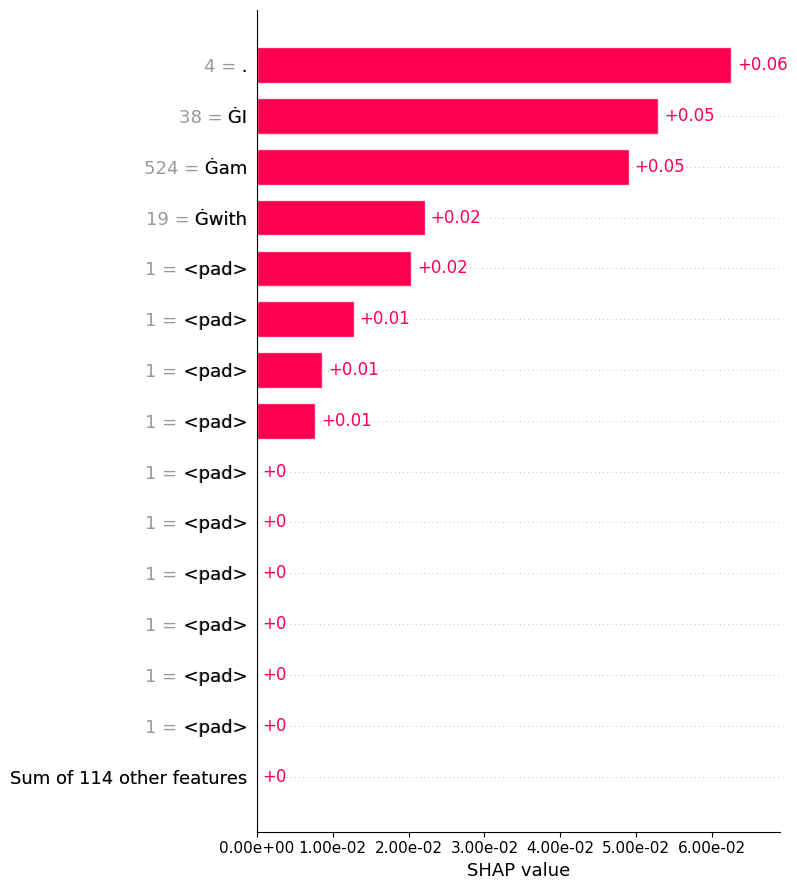


--- Contribution of Behavioral (Delta) Features ---


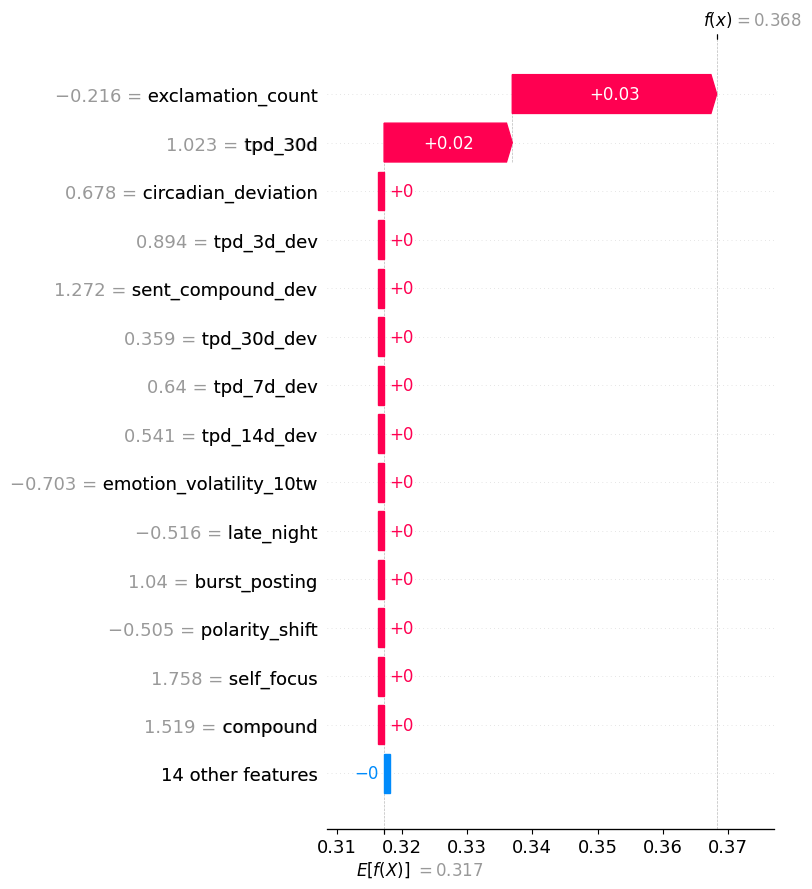

In [5]:
# Cell 5: NEW - The Manual Heatmap Plotting Function
import numpy as np
import shap
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable


try:
    # Newer SHAP (uses plots._labels)
    import shap.plots._labels as _shap_labels
    _shap_labels.format_value = lambda v, **_: f"{v:+.4e}" if np.isfinite(v) else str(v)
except Exception:
    # Older SHAP fallback
    if hasattr(shap, "format_value"):
        shap.format_value = lambda v: f"{v:+.4e}" if np.isfinite(v) else str(v)

if 'idx_to_explain' in locals() and idx_to_explain is not None:
    # Prepare the single instance and background data as before
    tokenized_instance = tokenizer(
        example_text,
        return_tensors='np',
        truncation=True,
        padding='max_length',
        max_length=128
    )
    input_ids = tokenized_instance['input_ids'][0]
    delta_values_np = example_delta_values.values.reshape(1, -1)

    shap_input = np.hstack([input_ids.reshape(1, -1), delta_values_np])[0]

    background_data = test_df.sample(50, random_state=42)
    tokenized_background = tokenizer(
        background_data['text'].tolist(),
        return_tensors='np',
        truncation=True,
        padding='max_length',
        max_length=128
    )
    background_ids = tokenized_background['input_ids']
    background_deltas = background_data[selected_features].values
    shap_background_full = np.hstack([background_ids, background_deltas])
    shap_background_summary = shap.kmeans(shap_background_full, 10)

    # --- THIS IS THE NEW, ROBUST LOGIC ---
    # 1) Fix the target label inside the predictor
    prediction_function = lambda x: shap_predict_single_class(x, class_index=target_label)

    # 2) KernelExplainer with summary background
    explainer = shap.KernelExplainer(prediction_function, shap_background_summary)

    print("Calculating SHAP values... (this may still take a moment)")
    # 3) Get a single, clean 1D array of shap values
    shap_values = explainer.shap_values(shap_input, nsamples=128)

    # 4) Single unified Explanation object
    text_tokens = tokenizer.convert_ids_to_tokens(input_ids)
    all_feature_names = text_tokens + selected_features
    full_explanation = shap.Explanation(
        values=shap_values,
        base_values=explainer.expected_value,
        data=shap_input,
        feature_names=all_feature_names
    )
    # ----------------------------------------------

    print("\n" + "="*50)
    print(f"--- SHAP EXPLANATION FOR '{class_names[target_label].upper()}' PREDICTION ---")
    print("="*50)

    print("\n--- Contribution of Text Features ---")
    # Use SHAP's bar plot for a clear view of top tokens
    ax = shap.plots.bar(full_explanation[:128], max_display=15, show=False)
    # Format x-axis ticks to show small values clearly (choose one formatter you prefer)
    ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))  # or '%.4f' / '%.6g'
    plt.tight_layout()
    plt.show()

    print("\n--- Contribution of Behavioral (Delta) Features ---")
    # The waterfall plot; our formatter patch controls the right-hand +values
    ax = shap.plots.waterfall(full_explanation[128:], max_display=15, show=False)
    plt.tight_layout()
    plt.show()
else:
    print("Skipping SHAP analysis because no example was found.")
